# Initialization

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf

# Helper libraries
import numpy as np
from numpy import random
import matplotlib.pyplot as plt
!pip install lifelines
from lifelines import KaplanMeierFitter

     |████████████████████████████████| 348 kB 38.1 MB/s 
     |████████████████████████████████| 55 kB 4.6 MB/s 
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4049 sha256=43d3f83e23dbd6e4b722d3da6d20b979bcee93f8b33525187af659090428427f
  Stored in directory: /root/.cache/pip/wheels/9f/01/ee/1331593abb5725ff7d8c1333aee93a50a1c29d6ddda9665c9f
Successfully built autograd-gamma


In [5]:
from typing import Any, Dict, Iterable, Tuple, Optional, Union
import pandas as pd
!pip install scikit-survival
from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.metrics import concordance_index_censored

     |████████████████████████████████| 2.4 MB 27.6 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
     |████████████████████████████████| 2.3 MB 32.6 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for scikit-survival: filename=scikit_survival-0.14.0-cp37-cp37m-linux_x86_64.whl size=4061634 sha256=e67129ee1c124172bc2327f1fc7392d6162610ce8ed4daf6dbb5fa30fe50a958
  Stored in directory: /root/.cache/pip/wheels/a2/3e/97/3722ba215d3dfe5429c1a7e4f24f535a3f46004fb29a16d505
Successfully built scikit-survival


# Importing data


In [2]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data(path='mnist.npz')
train_images = train_images/255
test_images = test_images/255
y = np.concatenate((train_labels,test_labels))
print(type(train_images[0]))

11501568/11490434 [==============================] - 0s 0us/step
<class 'numpy.ndarray'>


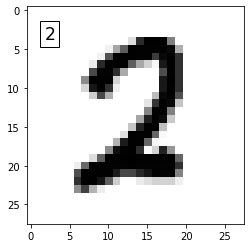

In [3]:
n = random.randint(len(train_images))
plt.figure()
plt.text(0.08,0.85, '{:.0f}'.format(train_labels[n]),transform=plt.gca().transAxes, bbox =dict(facecolor='white'), size = 'xx-large')
plt.imshow(train_images[n], cmap=plt.cm.binary)
#plt.colorbar()
plt.grid(False)
plt.show()

# Simulating survival data

56.58282075815676
[6.00845276e-01 3.95179207e+02 1.27022174e+00 ... 1.12320403e+00
 1.83982701e+00 4.47999331e-02] [ True False  True ...  True False  True]


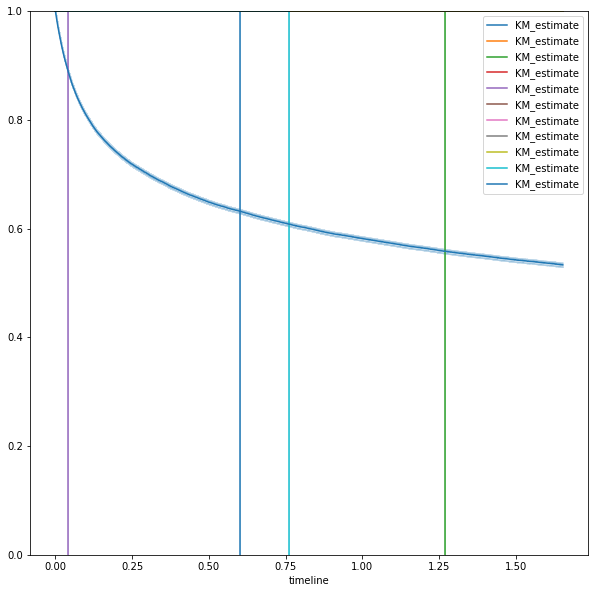

In [ ]:
noise = 0
average_surival_time = 350
censoring = 50

risk_score = train_labels + noise*(np.random.rand(len(train_labels))-0.5)
risk_score = [i if i > 0 else 0 for i in risk_score]

df = 1./average_surival_time * np.exp(risk_score)
T = -np.log(random.rand(len(df))) / df

qt = np.quantile(T, 1 - censoring/100)
c = (qt-min(T))*random.rand()+min(T)
print(sum(T)/len(T))
observed_event = T <= c
observed_time = np.where(observed_event, T, c)
#n = int(censoring/100*len(train_labels))
#m = len(train_labels)-n
#print(n,m)
plt.figure(figsize=[10,10])

for i in range(10):
  t = []
  ob = []
  for j in range(len(train_labels)):
    if train_labels[j] == i:
      t.append(observed_time[i])
      ob.append(observed_event[i])
  #print(t,ob)
  kmf.fit(t,ob)
  kmf.survival_function_
  kmf.plot_survival_function()
  plt.ylim(0,1)
  #print(len(t),len(ob))

censor = np.hstack((np.ones(n), np.zeros(m)))
np.random.shuffle(censor)
kmf = KaplanMeierFitter()
kmf.fit(observed_time,observed_event)
kmf.survival_function_
kmf.plot_survival_function()
#plt.ylim(0,1)
#plt.xlim(0,500)
#KP = [[T[i],observed_event[i]] for i in range(len(train_labels))]
#print(KP)

print(T,observed_event)


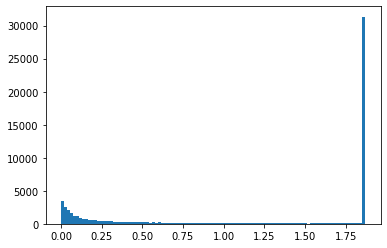

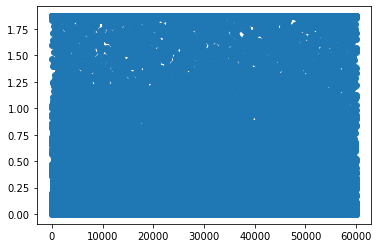

In [ ]:
plt.hist(x=observed_time, bins=100)
plt.show()
plt.scatter(range(len(observed_time)),observed_time)

# Simulated data (blog)

20.56% samples are right censored in training data.
20.36% samples are right censored in test data.


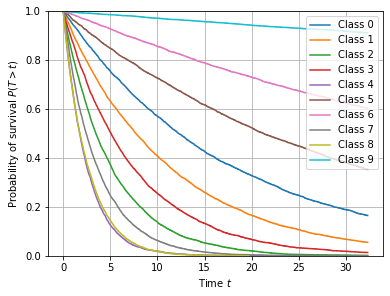

In [18]:
def make_risk_score_for_groups(y: np.ndarray,
                               n_groups: int = 10,
                               seed: int = 89) -> Tuple[pd.DataFrame, np.ndarray]:
    rnd = np.random.RandomState(seed)

    # assign class labels `y` to one of `n_groups` risk groups
    classes = np.unique(y)
    group_assignment = {}
    group_members = {}
    groups = rnd.randint(n_groups, size=classes.shape)
    for label, group in zip(classes, groups):
        group_assignment[label] = group
        group_members.setdefault(group, []).append(label)

    # assign risk score to each class label in `y`
    risk_per_class = {}
    for label in classes:
        group_idx = group_assignment[label]
        group = group_members[group_idx]
        label_idx = group.index(label)
        group_size = len(group)

        # allow risk scores in each group to vary slightly
        risk_score = np.sqrt(group_idx + 1e-4) * 1.75
        risk_score -= (label_idx - (group_size // 2)) / 25.
        risk_per_class[label] = risk_score

    assignment = pd.concat((
        pd.Series(risk_per_class, name="risk_score"),
        pd.Series(group_assignment, name="risk_group")
    ), axis=1).rename_axis("class_label")
        
    risk_scores = np.array([risk_per_class[yy] for yy in y])
    return assignment, risk_scores


risk_score_assignment, risk_scores = make_risk_score_for_groups(y)

risk_score_assignment.round(3)

class SurvivalTimeGenerator:

    def __init__(self,
                 num_samples: int,
                 mean_survival_time: float,
                 prob_censored: float) -> None:
        self.num_samples = num_samples
        self.mean_survival_time = mean_survival_time
        self.prob_censored = prob_censored

    def gen_censored_time(self,
                          risk_score: np.ndarray,
                          seed: int = 89) -> Tuple[np.ndarray,np.ndarray]:
        rnd = np.random.RandomState(seed)
        # generate survival time
        baseline_hazard = 1. / self.mean_survival_time
        scale = baseline_hazard * np.exp(risk_score)
        u = rnd.uniform(low=0, high=1, size=risk_score.shape[0])
        t = -np.log(u) / scale

        # generate time of censoring
        qt = np.quantile(t, 1.0 - self.prob_censored)
        c = rnd.uniform(low=t.min(), high=qt)

        # apply censoring
        observed_event = t <= c
        observed_time = np.where(observed_event, t, c)
        return observed_time, observed_event


surv_gen = SurvivalTimeGenerator(
    num_samples=y.shape[0],
    mean_survival_time=365.,
    prob_censored=.20
)
time, event = surv_gen.gen_censored_time(risk_scores)
time_train = time[:train_labels.shape[0]]
event_train = event[:train_labels.shape[0]]
time_test = time[train_labels.shape[0]:]
event_test = event[train_labels.shape[0]:]

print("%.2f%% samples are right censored in training data." % (np.sum(~event_train) * 100. / len(event_train)))
print("%.2f%% samples are right censored in test data." % (np.sum(~event_test) * 100. / len(event_test)))

styles = ('-', '--', '-.', ':')

plt.figure(figsize=(6, 4.5))
for row in risk_score_assignment.itertuples():
    mask = train_labels == row.Index
    coord_x, coord_y = kaplan_meier_estimator(event_train[mask], time_train[mask])
    #ls = styles[row.risk_group]
    plt.step(coord_x, coord_y, where="post", label=f"Class {row.Index}")
plt.ylim(0, 1)
plt.ylabel("Probability of survival $P(T > t)$")
plt.xlabel("Time $t$")
plt.grid()
plt.legend()

# Concordance

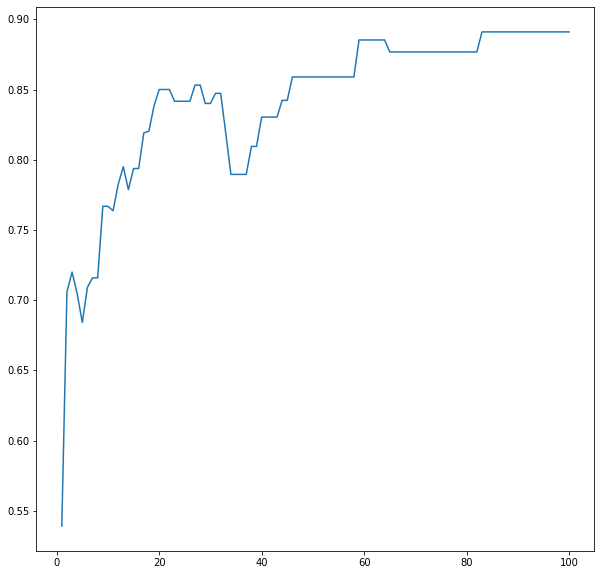

In [ ]:
c = []
groups = 100
for i in range(1,groups+1):
  risk_score_assignment, risk_scores = make_risk_score_for_groups(y,i)
  surv_gen = SurvivalTimeGenerator(
    num_samples=y.shape[0],
    mean_survival_time=365.,
    prob_censored=.45
  )
  time, event = surv_gen.gen_censored_time(risk_scores)
  time_train = time[:train_labels.shape[0]]
  event_train = event[:train_labels.shape[0]]
  time_test = time[train_labels.shape[0]:]
  event_test = event[train_labels.shape[0]:]
  cindex = concordance_index_censored(event_test, time_test, risk_scores[train_labels.shape[0]:])
  c.append(cindex[0])
  #print(f"Concordance index on test data with actual risk scores: {cindex[0]:.3f}")
#print(c)
plt.figure(figsize=[10,10])
plt.plot(range(1,groups+1),c)

In [ ]:
cindex = concordance_index_censored(event_test, time_test, risk_scores[train_labels.shape[0]:])

print(f"Concordance index on test data with actual risk scores: {cindex[0]:.3f}")

Concordance index on test data with actual risk scores: 0.891


# Risk set

In [20]:
size = 10
image_batch = train_images[:size]
time_batch = time_train[:size]
event_batch = event_train[:size]


print(train_labels[:size], time_batch,event_batch)

[5 0 4 1 9 2 1 3 1 4] [21.31328769 24.00630549  3.36518093 25.72269346 32.31275862 20.75801126
 20.72016793  5.34813434 25.39211888  2.17343369] [ True  True  True  True False  True  True  True  True  True]
